In [4]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler

#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM

from scipy.stats import ttest_ind_from_stats

import seaborn as sn


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


In [6]:
# Data loader
features = pd.read_csv("../FinalData/cleaned_features_2vs1_15112023.csv", low_memory=False)
outcomes = pd.read_csv("../FinalData/cleaned_outcomes_2vs1_15112023.csv")
# features = features[features.columns[1:]]
# outcomes = outcomes[outcomes.columns[1:]]

In [7]:
masterData = features.merge(outcomes, how = 'left', left_on='patid', right_on='patid') #join table
# masterData = masterData.dropna() #NAs from Country
masterData = masterData.reset_index(drop=True)
exclude_columns = ['weight', 'height', 'id', 'event_date', 'recorded_date', 'visit_id', 'code_id', 'snomed_id',
       'numeric_1', 'numeric_2', 'created_datetime', 'updated_datetime',]
masterData = masterData.loc[:,~masterData.columns.isin(exclude_columns)]
print('original data shape: ', masterData.shape)

original data shape:  (703586, 95)


In [8]:
#transform IMD
def transform_imd(x):
    if x == 0:
        return 'unknown'
    elif (x >=1) & (x <=3):
        return '1-3'
    elif (x >=4) & (x <=7):
        return '4-7'
    elif (x >=8) & (x <=10):
        return '>7'
        
masterData['cat_imd_decile'] = masterData.apply(lambda x: transform_imd(x['imd_decile']), axis=1)

In [9]:
#Data scenario
# 1: all data without ethnicity variable
# 2: all data with ethnicity variable (include all missing values in ethnicity as separate group)
# 3: filter data based on ethnicity (exclude missing values)

scenario = 1 #change it based on the scenario

if scenario == 1:
    #include all data
    allData = masterData
    
elif scenario == 2:
    #Exclude ethnic column
    allData = masterData.drop('ethnic_group', axis=1)
    
elif scenario == 3:
    #exclude missing values for ethnic variable
    allData = masterData[masterData.ethnic_group!='not_recorded']
    
allData = allData.reset_index(drop=True)
print('Data shape for scenario', str(scenario), allData.shape)



Data shape for scenario 1 (703586, 96)


In [10]:
#Split data into training and evaluation set based on the country. Include only 18+ patients.

trainingData = allData[(allData.Country == 'England') & (allData.age>=18)]
evaluationData = allData[((allData.Country == 'Scotland') | (allData.Country == 'Wales')) & (allData.age>=18)] #used for validation
evaluationDataWales = allData[(allData.Country == 'Wales') & (allData.age>=18)] #used for validation
evaluationDataScotland = allData[(allData.Country == 'Scotland') & (allData.age>=18)] #used for validation

#remove country variable
trainingData = trainingData.drop('Country', axis=1)
evaluationData = evaluationData.drop('Country', axis=1)
evaluationDataWales = evaluationDataWales.drop('Country', axis=1)
evaluationDataScotland = evaluationDataScotland.drop('Country', axis=1)

trainingData = trainingData.reset_index(drop=True)
evaluationData = evaluationData.reset_index(drop=True)
evaluationDataWales = evaluationDataWales.reset_index(drop=True)
evaluationDataScotland = evaluationDataScotland.reset_index(drop=True)

print('Training data shape:', trainingData.shape)
print('Evaluation data shape: ', evaluationData.shape)
print('Evaluation data Wales shape: ', evaluationDataWales.shape)
print('Evaluation data Scotland shape: ', evaluationDataScotland.shape)

Training data shape: (560957, 95)
Evaluation data shape:  (23520, 95)
Evaluation data Wales shape:  (14894, 95)
Evaluation data Scotland shape:  (8626, 95)


In [11]:
trainingData.columns

Index(['patid', 'practice_id', 'sex', 'age', 'BMI', 'ethnicity',
       'ethnic_group', 'smokingStatus', 'CharlsonScore', 'count_rhinitis',
       'count_cardiovascular', 'count_heartfailure', 'count_psoriasis',
       'count_anaphylaxis', 'count_diabetes', 'count_ihd', 'count_anxiety',
       'count_eczema', 'count_nasalpolyps', 'count_paracetamol',
       'count_nsaids', 'count_betablocker', 'PEFStatus', 'EosinophilLevel',
       'BTS_step', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS',
       'ICS_medication_possesion_ratio', 'DeviceType', 'Spacer', 'numOCS',
       'PriorEducation', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents',
       'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI',
       'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'month_12',
       'month_1', 'month_3', 'month_4', 'month_5', 'month_7', 'month_10',
       'month_6', 'month_11', 'month_9', 'month_2', 'month_8',
       'postcode_district', 'imd_decile', 'County', 'LocalAuthori

In [13]:
cat_vars = ['sex', 'cat_age', 'cat_BMI', 'ethnic_group', 'smokingStatus', 'system', 'CharlsonScore', 'rhinitis',
       'cardiovascular', 'heartfailure', 'psoriasis',
       'anaphylaxis', 'diabetes', 'ihd', 'anxiety',
       'eczema', 'nasalpolyps', 'paracetamol',
       'nsaids', 'betablocker', 'PEFStatus', 'EosinophilLevel',
       'BTS_step', 'DeviceType', 'cat_imd_decile',  
       'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS',
       'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents',
       'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents',
       'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI',
       'cat_numAsthmaAttacks', 'cat_numHospEvents', 'cat_numPCS',
       'cat_numPCSAsthma']

cont_vars = ['age']

In [14]:
trainingData['set'] = 'training'
evaluationData['set'] = 'eval'
evaluationDataWales['set'] = 'Wales'
evaluationDataScotland['set'] = 'Scotland'

In [15]:
ttest_vars = ['age', 'numOCS', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents',
       'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI',
       'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents']
for var in ttest_vars:
    print(var)
    print(ttest_ind(trainingData[var].values, evaluationData[var].values))

age
Ttest_indResult(statistic=-3.175636923568368, pvalue=0.0014951570520788187)
numOCS
Ttest_indResult(statistic=-14.880265675837093, pvalue=4.522035928163152e-50)
numPCS
Ttest_indResult(statistic=23.826534931853843, pvalue=2.0363467975461158e-125)
numPCSAsthma
Ttest_indResult(statistic=-0.6673022594281186, pvalue=0.5045793469124816)
numAntibioticsEvents
Ttest_indResult(statistic=-21.567485629590117, pvalue=3.9821709222856345e-103)
numAntibioticswithLRTI
Ttest_indResult(statistic=-28.847427098849824, pvalue=7.342494271762964e-183)
numOCSEvents
Ttest_indResult(statistic=-14.880265675837093, pvalue=4.522035928163152e-50)
numOCSwithLRTI
Ttest_indResult(statistic=-27.045223553551725, pvalue=5.467129265547677e-161)
numAsthmaAttacks
Ttest_indResult(statistic=-31.59939618899711, pvalue=5.766849487177176e-219)
numAcuteRespEvents
Ttest_indResult(statistic=-45.963321374295994, pvalue=0.0)
numHospEvents
Ttest_indResult(statistic=-93.69616994601323, pvalue=0.0)


In [11]:
# for var in ttest_vars:
#     sn.histplot(x=var, data=trainingData, fill=True)
#     sn.histplot(x=var, data=evaluationData, fill=True)
#     plt.show()

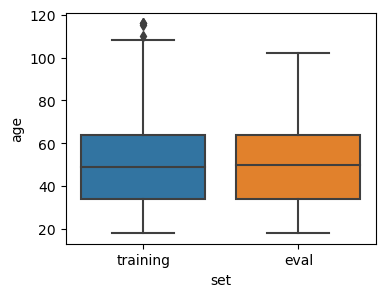

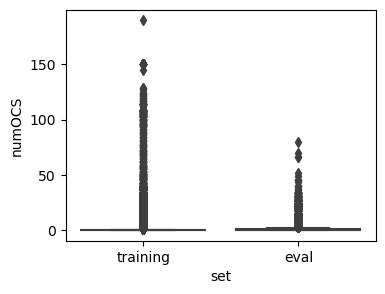

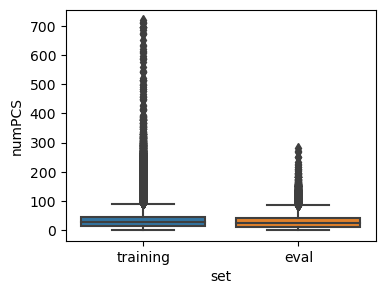

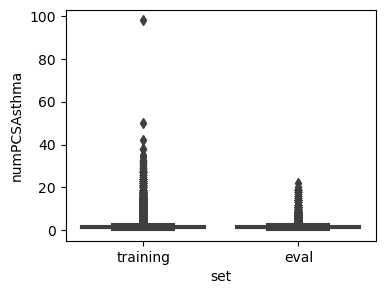

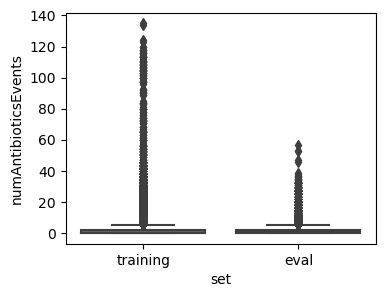

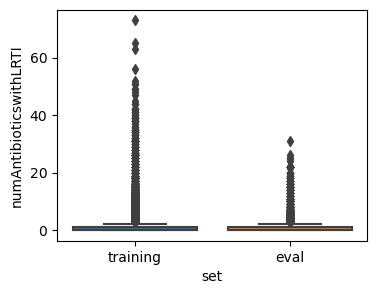

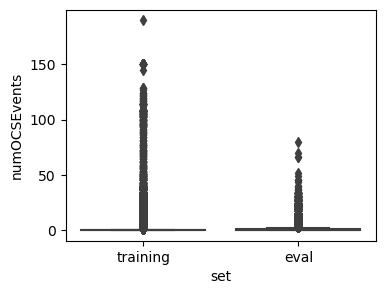

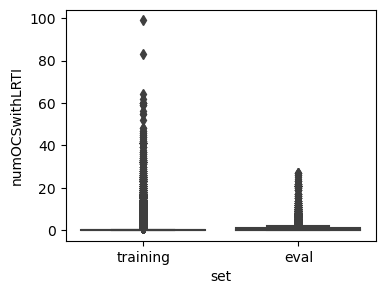

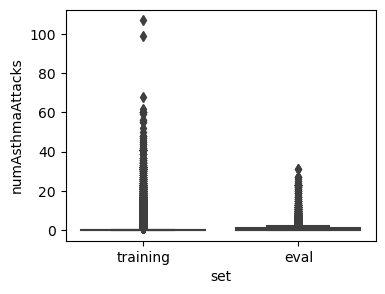

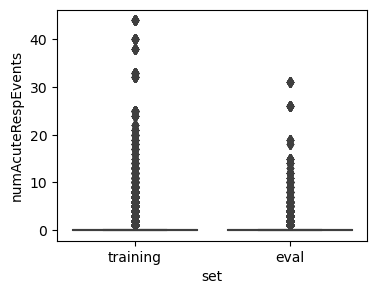

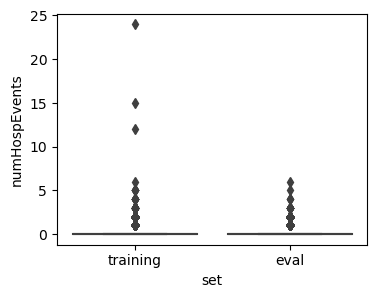

In [16]:
import seaborn as sn
for var in ttest_vars:
    plt.figure(figsize=(4,3))
    var_set = [var, 'set']
    df = pd.concat([trainingData[var_set], evaluationData[var_set]])
    df.reset_index(drop=True, inplace=True)
    sn.boxplot(x=var_set[1], y=var_set[0], data=df)
    plt.show()
    

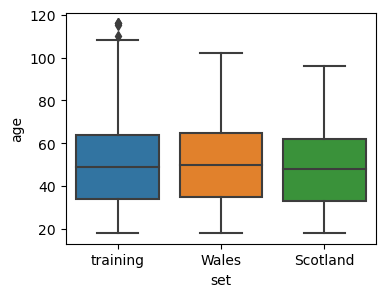

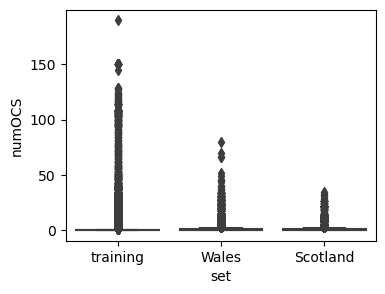

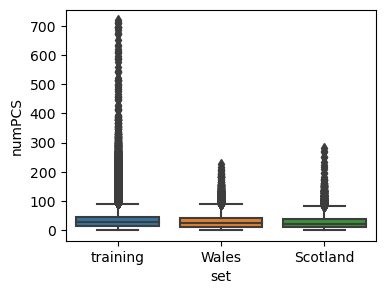

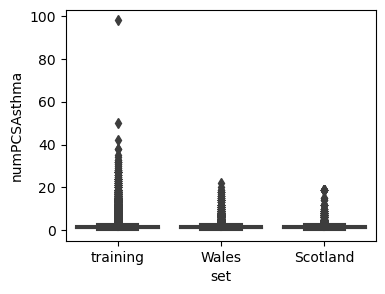

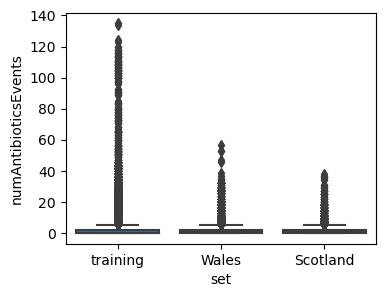

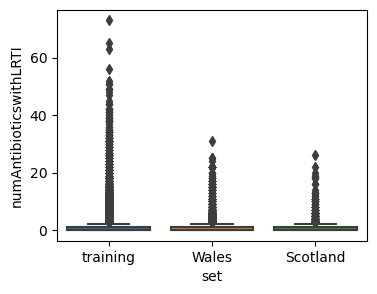

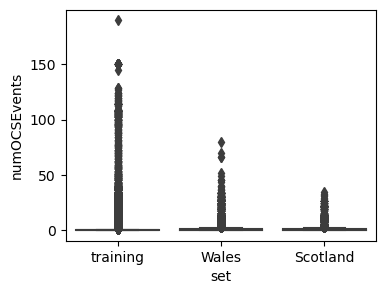

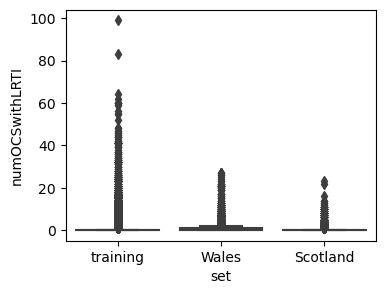

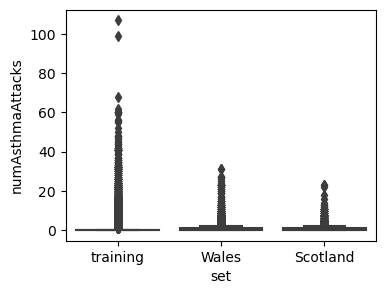

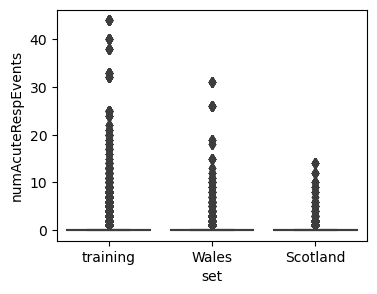

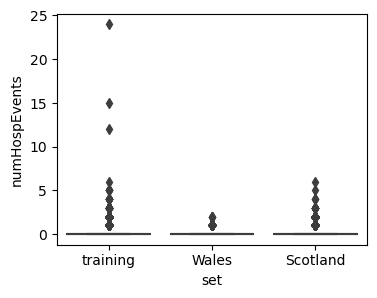

In [17]:
import seaborn as sn
for var in ttest_vars:
    plt.figure(figsize=(4,3))
    var_set = [var, 'set']
    df = pd.concat([trainingData[var_set], evaluationDataWales[var_set], evaluationDataScotland[var_set]])
    df.reset_index(drop=True, inplace=True)
    sn.boxplot(x=var_set[1], y=var_set[0], data=df)
    plt.show()
    

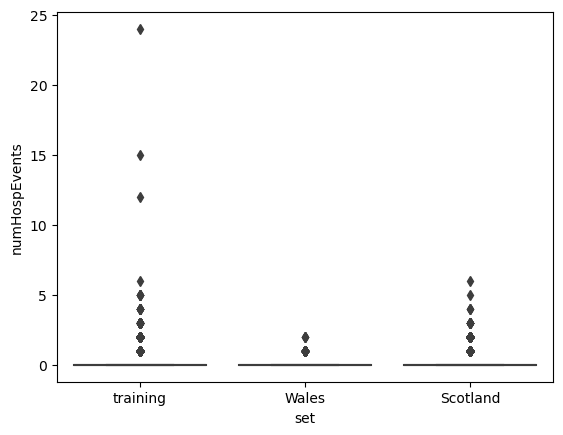

In [18]:
import seaborn as sn
sn.boxplot(x=var_set[1], y=var_set[0], data=df)
plt.show()

In [15]:
trainingData[var_set[0]].describe()

count    555836.000000
mean          0.005770
std           0.084326
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: numHospEvents, dtype: float64

In [16]:
evaluationData[var_set[0]].describe()

count    22126.000000
mean         0.051026
std          0.233024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: numHospEvents, dtype: float64

In [22]:
writer = pd.ExcelWriter('../FinalData/descriptive_cat_ScotWales_new.xlsx', engine='xlsxwriter')
target_outcome = '12MonthsOutcome'
sets = [trainingData, evaluationData, evaluationDataWales, evaluationDataScotland]
setsName = ['trainingData', 'evaluationData', 'evaluationDataWales', 'evaluationDataScotland']
# cat_vars = ['gender_x', 'language', 'marital_status', 'ethnicity', 'admission_location', 'discharge_location']
for data, setname in zip(sets, setsName):
    desc_table = []
    for var in data.columns:
        if (var in cont_vars):
            desc_table.append((var  + ' (n, % of total)','-' ,'-'))
            noAsthmaMean = np.round(np.mean(data[var][data[target_outcome]==0]),2)
            noAsthmaSD = np.round(np.std(data[var][data[target_outcome]==0]),2)
            asthmaMean = np.round(np.mean(data[var][data[target_outcome]==1]),2)
            asthmaSD = np.round(np.std(data[var][data[target_outcome]==1]),2)
            desc_table.append((var  + ' (mean, std)', str(noAsthmaMean)  + ' (' + str(noAsthmaSD) + ')', str(asthmaMean) + ' (' + str(asthmaSD) + ')'))
        elif (var in cat_vars):
            desc_table.append((var  + ' (n, % of total)','-' ,'-'))
            groups = data[var].unique().tolist()
            groups.sort()
            for group in groups:
                noAsthma = data[(data[var]==group)&(data[target_outcome]==0)].shape[0]
                noAsthmaPercent = round(noAsthma/sum(data[target_outcome]==0)*100,2)
                asthma = data[(data[var]==group)&(data[target_outcome]==1)].shape[0]
                asthmaPercent = round(asthma/sum(data[target_outcome]==1)*100,2)
                desc_table.append((group, str(noAsthma) + ' (' + str(noAsthmaPercent) + '%)' , str(asthma) + ' (' + str(asthmaPercent) + '%)'))
    descriptive_cat = pd.DataFrame(desc_table, columns=['var','No asthma attack (N='+str(sum(data[target_outcome]==0))+')', 'Asthma attack (N='+str(sum(data[target_outcome]==1))+')'])
    descriptive_cat.to_excel(writer, sheet_name=setname)
    print('writing to Excel done!!')
writer.save()

writing to Excel done!!
writing to Excel done!!
writing to Excel done!!
writing to Excel done!!


/tmp/ipykernel_1355794/4269595197.py:29: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
